In [14]:
import sys
import os
from os.path import exists
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle as pkl

sys.path.insert(1,'/data1/gridsan/groups/manthiram_lab/Utils')
import plot as pl
from utils import make_xyz_from_output,checkvibs, check, no_to_symbol
from PyEnergyDiagrams.energydiagram import ED

# Load Necessary Data

In [4]:
df=pd.read_csv('../sheets/Ylides_YlideRads_Cleaned.csv')
y=df['Ylides'].to_list()
yr=df['Ylides Rad'].to_list()
yh=df['Ylides H'].to_list()

In [5]:
with open("../pickled_data/num_atoms.pkl","rb") as file: #This may have been overwritten in the data_analysis code
    pickle_off = pkl.Unpickler(file)
    num_atoms= pickle_off.load()

with open("../pickled_data/num_atoms_total.pkl","rb") as file: #This may have been overwritten in the data_analysis code
    pickle_off = pkl.Unpickler(file)
    num_atoms_total= pickle_off.load()
    
with open("../pickled_data/wall_time_gas.pkl","rb") as file: #This may have been overwritten in the data_analysis code
    pickle_off = pkl.Unpickler(file)
    wall_time_gas= pickle_off.load()
    
with open("../pickled_data/wall_time_solv.pkl","rb") as file: #This may have been overwritten in the data_analysis code
    pickle_off = pkl.Unpickler(file)
    wall_time_solv= pickle_off.load()   
    
with open("../pickled_data/failed_dict_gas.pkl","rb") as file: #This may have been overwritten in the data_analysis code
    pickle_off = pkl.Unpickler(file)
    failed_dict_gas= pickle_off.load()
    
with open("../pickled_data/failed_dict_solv.pkl","rb") as file: #This may have been overwritten in the data_analysis code
    pickle_off = pkl.Unpickler(file)
    failed_dict_solv= pickle_off.load()
    
with open("../pickled_data/bde_dict.pkl","rb") as file: #This may have been overwritten in the data_analysis code
    pickle_off = pkl.Unpickler(file)
    bde_dict= pickle_off.load()   

data_gas=np.load(f'../pickled_data/data_gas.npy')
data_solv=np.load(f'../pickled_data/data_solv.npy')
data=[data_gas,data_solv]
wall_time=[wall_time_gas,wall_time_solv]

In [6]:
dicts= [failed_dict_gas, failed_dict_solv]
succ=[[],[]]
all_failures=[[],[]]

special_cases=[[262, 775, 264, 266, 655, 275, 663, 667, 926, 671, 419, 678, 570,
       826, 833, 963, 324, 581, 708, 583, 323, 326, 970, 971, 972, 848,
       593, 594, 852, 862, 478, 480, 485, 748, 620, 624, 625, 628, 118,
       887, 505],[]]

special_cases=[[4610, 6147, 6660, 5637, 1031, 1543, 5641, 9364, 4617, 5129, 1039,
       9232, 1551, 4624, 9241, 7194, 9242, 3100, 9757, 9246, 7199, 8735,
       7713, 9249, 4131, 7203, 7716, 9254, 9255, 7208, 9763, 9769, 6189,
       8750, 7216, 9782, 6199, 7223, 9783,  570, 1082, 6202, 8250, 2616,
       3647, 3648, 9793, 1093, 1096, 2632, 3146, 4681, 4684, 5705, 8780,
       2125,  593,  594, 4690, 9298, 4692, 4694, 1112, 4696, 1626, 1117,
       4701, 4702, 1632, 6240, 6238, 2147, 7788, 5745, 8818,  628, 1652,
        118, 9850, 3707, 6780, 4733, 5249, 5768, 7305, 8841, 3724,  655,
       7312, 7313, 9362, 3219, 3732, 7315, 4246, 6807, 7317, 4249, 7320,
        667, 7322, 7828, 7829,  671, 2719, 7841, 8349, 8350, 3236, 2213,
        678, 1190, 2214, 2215, 3754, 2731, 5799, 5802, 5804, 9387, 7856,
       7345, 5810, 2218, 7348, 9397, 9389, 6839, 5816, 2237, 3775,  708,
       6346, 3279, 9424, 7892, 1242, 4317, 1246, 4318, 6878, 6371, 3303,
        748, 1261, 6894, 1263, 3312, 6895, 7404, 7406, 7919, 8435, 9974,
       2295, 7418, 5371, 1353, 5885, 8448, 4357,  262,  775,  264, 3847,
        266, 1290, 4358, 6409, 8969, 3853, 5392, 8977,  275, 4885, 2841,
       8988, 3869, 6432, 5413, 6437, 6949, 6950, 7464, 7974, 7975, 7977,
       8492, 6958, 7471, 9015, 6454, 4919, 6455, 9526,  826, 9018, 1852,
       5948, 6461, 5434, 4416,  833, 4418,  323,  324,  326, 1350, 1865,
       3913, 1355, 5449, 8525, 4942, 3919, 8015, 8528, 6994, 9043, 1872,
       5973, 1878,  862, 1888, 8040, 1388, 6509, 7021, 8048, 2930, 9075,
       4984, 9081, 5501, 8062, 4477, 3462, 1927, 3463, 2441, 4486, 9614,
       5012, 3481, 5529, 2459, 7578, 8603,  926, 2464, 6564, 3494, 3497,
       1454, 2991, 2992, 5554, 4023, 4024, 9657, 9658, 4029, 4030, 4031,
       4032, 6077,  963, 1987, 1988, 5572, 7619, 5064, 9674,  972, 7116,
       8146, 9683, 6100, 4565, 6101, 8150, 7134, 5087,  480, 8673, 8674,
       2531, 8847,  485, 7146, 7660, 7662, 5103, 5104, 6127, 4780, 8342,
       8851, 5108, 7670, 1015, 4086,  505],[]]

for i,v in enumerate(dicts):
    for key, value in v.items():
        all_failures[i]= all_failures[i]+ value

    for j in special_cases[i]:
        all_failures[i].append(j)

    all_failures[i]=list(set(all_failures[i]))

    all_failures[i].sort()

    #Get Values that worked

    n,d=np.shape(data[i])

    for j in range(n):
        if j not in all_failures[i]:
            succ[i].append(j)
        



## Plot Characteristics of Ylide Library

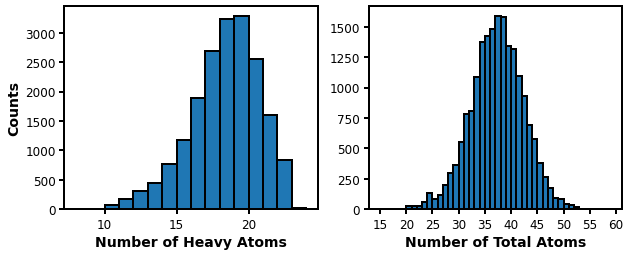

In [15]:
#plot
b=list(range(8,25))
b2=list(range(15,60))
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,10))
pl.hist(ax1,num_atoms,bins=b,xlabel='Number of Heavy Atoms',ylabel='Counts',fontsize=14,labelsize=12)
pl.hist(ax2,num_atoms_total,bins=b2,xlabel='Number of Total Atoms',ylabel='',fontsize=14,labelsize=12)
max_xticks = 10
xloc = plt.MaxNLocator(max_xticks)
ax1.xaxis.set_major_locator(xloc)
ax2.xaxis.set_major_locator(xloc)
plt.savefig(f'../Figures/Num_atoms.png',dpi=600)

# Time Statistics

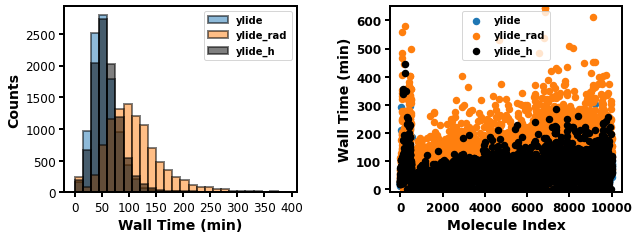

In [16]:
#gas phase
ylide_type=[['ylide',''],['ylide_rad','_y_h_opt'],['ylide_h','']]
solvorgas='gas'
#wall_time=wall_time_gas

b=list(range(0,400,15))
#b2=list(range(15,60))
wt=0

wall_time_array=np.array(wall_time[wt])
n,d=np.shape(wall_time_array)
colors=['tab:blue','tab:orange','black']
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,10))

for i in range(3):
    #pl.hist(ax1,list(np.reshape(wall_time_array,(1,n*d))/60),bins=b,xlabel='Wall Time (min)',ylabel='Counts',fontsize=14,labelsize=12)
    pl.hist(ax1,wall_time_array[i,:]/60,bins=b,xlabel='Wall Time (min)',ylabel='Counts',fontsize=14,labelsize=12,color=colors[i],alpha=0.5,label=f'{ylide_type[i][0]}')
ax1.legend(prop={'family':'arial','size':10,'weight':'bold'}) 
    
ax2.set_ylim(-10,650)


for i in range(3):
    pl.scatter(ax2,range(d),wall_time_array[i,:]/60,xlabel='Molecule Index',ylabel='Wall Time (min)',label=f'{ylide_type[i][0]}',fontsize=14,labelsize=12,facecolor=colors[i],edgecolor=colors[i])

    
ax2.legend(prop={'family':'arial','size':10,'weight':'bold'})  
max_xticks = 10
xloc = plt.MaxNLocator(max_xticks)
#ax1.xaxis.set_major_locator(xloc)
ax1.xaxis.set_major_locator(xloc)

plt.subplots_adjust(wspace=0.4)
plt.savefig(f'../Figures/Wall_time_{solvorgas}.png',dpi=600)

In [8]:
for i in range(3):
    print(wall_time_array[i][np.nonzero(wall_time_array[i])].mean()/3600)
    

0.9333181629539897
1.909661677260611
1.0235573168124064


In [15]:
special_gas_cases_1=np.where(data_gas[:,9]<-400) 
special_gas_cases_2=np.where(data_gas[:,7]>6 )
np.array(list(set(np.concatenate((special_gas_cases_1[0], special_gas_cases_2[0])))))

array([4610, 6147, 6660, 5637, 1031, 1543, 5641, 9364, 4617, 5129, 1039,
       9232, 1551, 4624, 9241, 7194, 9242, 3100, 9757, 9246, 7199, 8735,
       7713, 9249, 4131, 7203, 7716, 9254, 9255, 7208, 9763, 9769, 6189,
       8750, 7216, 9782, 6199, 7223, 9783,  570, 1082, 6202, 8250, 2616,
       3647, 3648, 9793, 1093, 1096, 2632, 3146, 4681, 4684, 5705, 8780,
       2125,  593,  594, 4690, 9298, 4692, 4694, 1112, 4696, 1626, 1117,
       4701, 4702, 1632, 6240, 6238, 2147, 7788, 5745, 8818,  628, 1652,
        118, 9850, 3707, 6780, 4733, 5249, 5768, 7305, 8841, 3724,  655,
       7312, 7313, 9362, 3219, 3732, 7315, 4246, 6807, 7317, 4249, 7320,
        667, 7322, 7828, 7829,  671, 2719, 7841, 8349, 8350, 3236, 2213,
        678, 1190, 2214, 2215, 3754, 2731, 5799, 5802, 5804, 9387, 7856,
       7345, 5810, 2218, 7348, 9397, 9389, 6839, 5816, 2237, 3775,  708,
       6346, 3279, 9424, 7892, 1242, 4317, 1246, 4318, 6878, 6371, 3303,
        748, 1261, 6894, 1263, 3312, 6895, 7404, 74

In [16]:
max_red=np.max(data_gas[succ[0],7])
ind=np.where(data_gas[:,7]==max_red)

ind[0][0]


1

In [31]:
succ[0]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,


### Make Gas Data Frame Removing All Failures

In [17]:
cleaned_gas=np.empty((len(succ[0]),5),dtype='object')
for i,v in enumerate(succ[0]):
    d=data[0]
    cleaned_gas[i,0]= y[v]
    cleaned_gas[i,1]= d[v,7] #Redox
    cleaned_gas[i,2]= d[v,8] #DP
    cleaned_gas[i,3]= d[v,9] #GHbind
    cleaned_gas[i,4]= v

df=pd.DataFrame(data=cleaned_gas,columns=['smiles','redox potential (V)','DPFE (kJ/mol)','GHbind (kJ/mol)','Original Index'])
df.to_csv('Ylide_Gas_SpecialCases_Removed.csv',index=False)

### Gas Phase

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


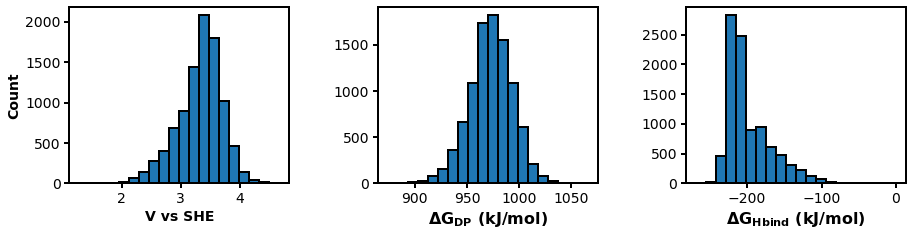

In [18]:
functional='M062X'
basis= 'Def2TZVP'
solvorgas='gas'
solvmethod='SMD'

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'


# b=list(np.arange(1,5,0.1))
# #b2=list(np.arange(250,500,5))
# b2=list(np.arange(850,1100,5))
# b3=list(np.arange(-300,0,5))


fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,15))
# pl.hist(ax1,data[0][succ[0],7],bins=b,color='tab:blue',xlabel='V vs SHE',ylabel='Count',labelsize=14,fontsize=14)
# pl.hist(ax2,data[0][succ[0],8],bins=b2,color='tab:blue',xlabel=f'{dpfe} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
# pl.hist(ax3,data[0][succ[0],9],bins=b3,color='tab:blue',xlabel=f'{ghb} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
pl.hist(ax1,data[0][succ[0],7],color='tab:blue',xlabel='V vs SHE',ylabel='Count',labelsize=14,fontsize=14)
pl.hist(ax2,data[0][succ[0],8],color='tab:blue',xlabel=f'{dpfe} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
pl.hist(ax3,data[0][succ[0],9],color='tab:blue',xlabel=f'{ghb} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
max_xticks = 8
xloc = plt.MaxNLocator(max_xticks)
#ax1.xaxis.set_major_locator(xloc)
#ax2.xaxis.set_major_locator(xloc)

plt.subplots_adjust(wspace=0.4)
plt.savefig(f'../Figures/Energy_Hist_{solvorgas}.png',dpi=600)

### Solution Phase

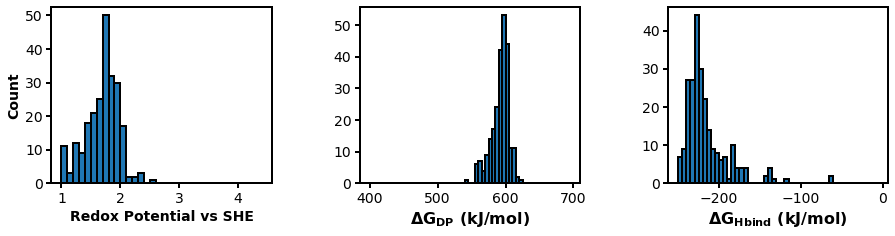

In [35]:
#Solution Phase
functional='M062X'
basis= 'Def2TZVP'
solvorgas='solv'
solvmethod='SMD'

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

b=list(np.arange(1,4.5,0.1))
b2=list(np.arange(400,700,5))
b3=list(np.arange(-250,0,5))

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,15))
pl.hist(ax1,data[1][succ[1],7],bins=b,color='tab:blue',xlabel='Redox Potential vs SHE',ylabel='Count',labelsize=14,fontsize=14)
pl.hist(ax2,data[1][succ[1],8],bins=b2,color='tab:blue',xlabel=f'{dpfe} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
pl.hist(ax3,data[1][succ[1],9],bins=b3,color='tab:blue',xlabel=f'{ghb} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
max_xticks = 8
xloc = plt.MaxNLocator(max_xticks)
#ax1.xaxis.set_major_locator(xloc)
#ax2.xaxis.set_major_locator(xloc)
plt.subplots_adjust(wspace=0.4)
#pl.hist(ax,pople_array[:,7],bins=b,color='tab:orange',xlabel='V vs SHE',ylabel='Count')
plt.savefig(f'Figures/Energy_Hist_{solvorgas}.png',dpi=600)

# Scatter Plots

### Gas phase

findfont: Font family ['DejaVuSans'] not found. Falling back to DejaVu Sans.


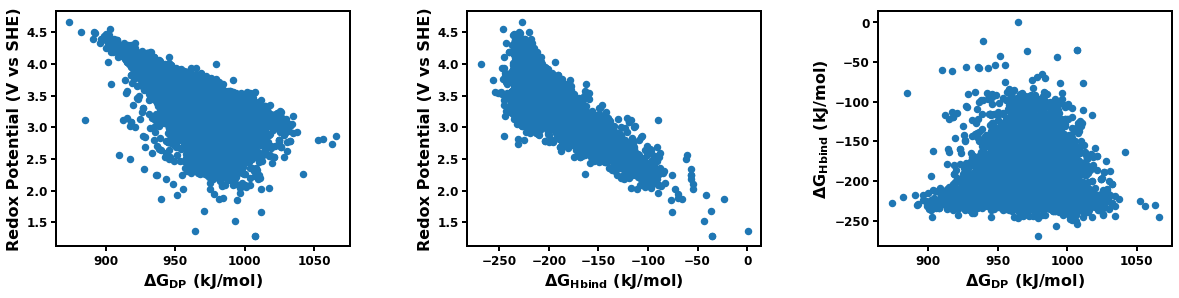

In [18]:
#plot
#Solution Phase
functional='M062X'
basis= 'Def2TZVP'
solvorgas='gas'
solvmethod='SMD'

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

ylide_type=[['ylide',''],['ylide_rad','_y_h_opt'],['ylide_h','']]
colors=['tab:blue','tab:orange','black']
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))

# ax1.set_xlim(300,500)
# ax1.set_ylim(1.5,5.0)

# ax2.set_xlim(-300,0)
# ax2.set_ylim(1.5,5.0)

# ax3.set_ylim(-300,0)
# ax3.set_xlim(300,500)

# ax1.set_ylim(-700,-500)
# ax1.set_xlim(1.0,3.0)

# ax2.set_ylim(-300,0)
# ax2.set_xlim(1.0,3.0)

# ax3.set_ylim(-300,0)
# ax3.set_xlim(-700,-500)

pl.scatter(ax1,data[0][succ[0],8],data[0][succ[0],7],ylabel='Redox Potential (V vs SHE)',xlabel=f'{dpfe} (kJ/mol)',fontsize=16,labelsize=12)
pl.scatter(ax2,data[0][succ[0],9],data[0][succ[0],7],ylabel='Redox Potential (V vs SHE)',xlabel=f'{ghb} (kJ/mol)',fontsize=16,labelsize=12)
pl.scatter(ax3,data[0][succ[0],8],data[0][succ[0],9],xlabel=f'{dpfe} (kJ/mol)',ylabel=f'{ghb} (kJ/mol)',fontsize=16,labelsize=12)



plt.subplots_adjust(wspace=0.4)
#ax1.legend(prop={'family':'arial','size':8,'weight':'bold'},loc='upper center',ncol=3,fancybox=True,bbox_to_anchor=(0.5, 1.25)) 
# ax.legend(loc='upper center', bbox_to_anchor=(0., 1.05),
#           ncol=3, fancybox=True, shadow=True)

plt.savefig(f'../Figures/Energy_Scatter_{solvorgas}.png',dpi=600)

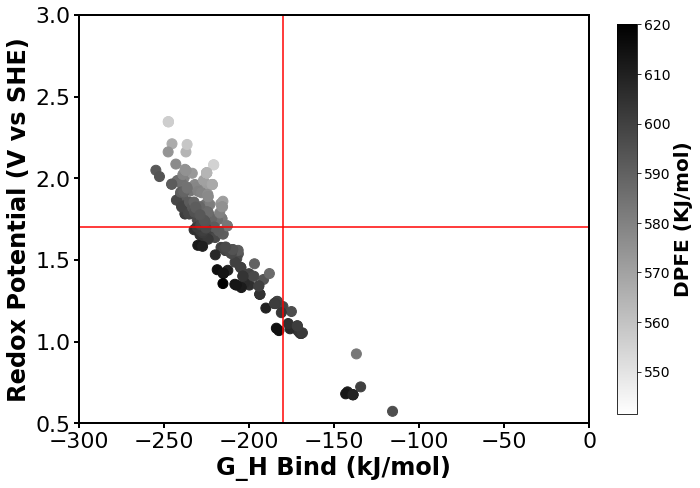

In [45]:
fig,ax1=plt.subplots(1,1,figsize=(10,10))

solvorgas='solv'

data_id={
    'solv':1,
    'gas':0
}
di=data_id[solvorgas]

sc=ax1.scatter(data[di][succ[di],9],data[di][succ[di],7],s=100,c=data[di][succ[di],8],cmap='binary',vmin=min(data[di][succ[di],8]),vmax=max(data[di][succ[di],8]))
ax1.set_xlim(-300,0)
ax1.set_ylim(0.5,3)
# mat = np.random.random(data[succ_gas,9])
plt.axhline(y=1.7, xmin=0, xmax=1,color='r')
plt.axvline(x=-180, ymin=0, ymax=1,color='r')
cb=plt.colorbar(sc,fraction=0.035, pad=0.05)
cb.set_label(label='DPFE (KJ/mol)',size=20,weight='bold')
cb.ax.tick_params(labelsize=14) 
pl.set(ax1,ylabel='Redox Potential (V vs SHE)',xlabel='G_H Bind (kJ/mol)',edgecolor='black')

plt.savefig(f'Figures/Energy_Scatter_3D{solvorgas}.png',dpi=600)

## Solution phase

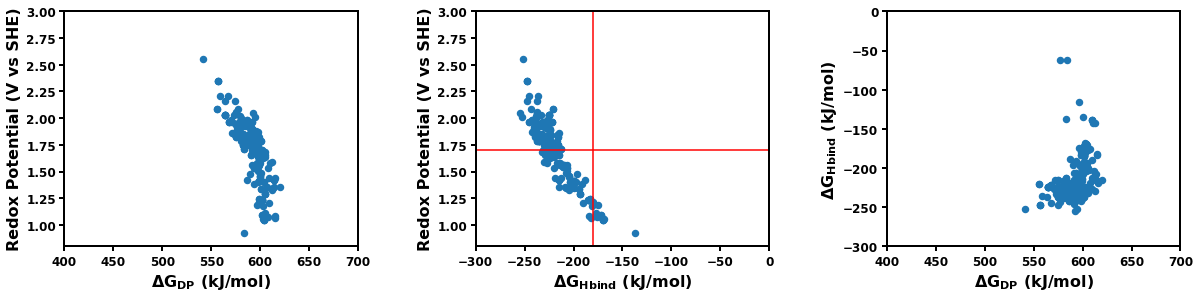

In [37]:

#Solution Phase

functional='M062X'
basis= 'Def2TZVP'
solvorgas='solv'
solvmethod='SMD'

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'


ylide_type=[['ylide',''],['ylide_rad','_y_h_opt'],['ylide_h','']]
colors=['tab:blue','tab:orange','black']
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))

ax1.set_xlim(400,700)
ax1.set_ylim(0.8,3)

ax2.set_xlim(-300,0)
ax2.set_ylim(0.8,3)

ax3.set_ylim(-300,0)
ax3.set_xlim(400,700)

# ax1.set_ylim(-700,-500)
# ax1.set_xlim(1.0,3.0)

# ax2.set_ylim(-300,0)
# ax2.set_xlim(1.0,3.0)

# ax3.set_ylim(-300,0)
# ax3.set_xlim(-700,-500)

pl.scatter(ax1,data[1][succ[1],8],data[1][succ[1],7],ylabel='Redox Potential (V vs SHE)',xlabel=f'{dpfe} (kJ/mol)',fontsize=16,labelsize=12)
pl.scatter(ax2,data[1][succ[1],9],data[1][succ[1],7],ylabel='Redox Potential (V vs SHE)',xlabel=f'{ghb} (kJ/mol)',fontsize=16,labelsize=12)
ax2.axhline(y=1.7, xmin=0, xmax=1,color='r')
ax2.axvline(x=-180, ymin=0, ymax=1,color='r')
pl.scatter(ax3,data[1][succ[1],8],data[1][succ[1],9],xlabel=f'{dpfe} (kJ/mol)',ylabel=f'{ghb} (kJ/mol)',fontsize=16,labelsize=12)



plt.subplots_adjust(wspace=0.4)
#ax1.legend(prop={'family':'arial','size':8,'weight':'bold'},loc='upper center',ncol=3,fancybox=True,bbox_to_anchor=(0.5, 1.25)) 
# ax.legend(loc='upper center', bbox_to_anchor=(0., 1.05),
#           ncol=3, fancybox=True, shadow=True)

plt.savefig(f'Figures/Energy_Scatter_{solvorgas}.png',dpi=600)

findfont: Font family ['DejaVuSans'] not found. Falling back to DejaVu Sans.


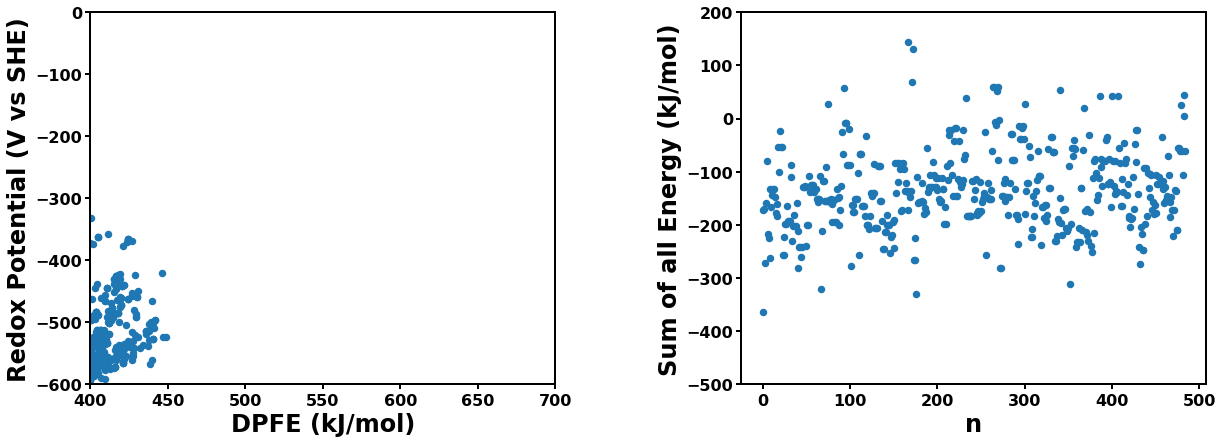

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

ax1.set_xlim(400,700)
ax1.set_ylim(-600,0)
pl.scatter(ax1,data[0][succ[0],8],data[0][succ[0],7]*(-96.45)+data[0][succ[0],9],ylabel='Redox Potential (V vs SHE)',xlabel='DPFE (kJ/mol)',fontsize=24,labelsize=16)


ax2.set_ylim(-500,200)
pl.scatter(ax2,range(len(data[0][succ[0],8])),data[0][succ[0],8] + data[0][succ[0],7]*(-96.45)+data[0][succ[0],9],ylabel='Sum of all Energy (kJ/mol)',xlabel='n',fontsize=24,labelsize=16)
plt.subplots_adjust(wspace=0.4)

In [77]:
np.mean(data[0][succ[0],8] + data[0][succ[0],7]*(-96.45)+data[0][succ[0],9])

-135.54355312107361

In [76]:
np.std(data[0][succ[0],8] + data[0][succ[0],7]*(-96.45)+data[0][succ[0],9])

72.86684797297809

23.000000000000576

# Energy Levels

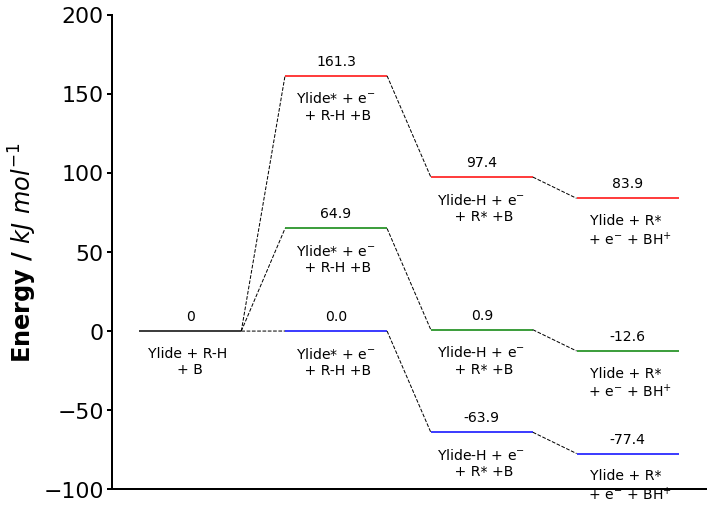

In [77]:
solvorgas='solv'
prot='H$\mathregular{^{+}}$'
elect='e$\mathregular{^{-}}$'
rh=-540.888642*2625.5 #kJ/mol
r_rad= -540.240640*2625.5 #kJ/mol
h_rad=-0.508404*2625.5 #kJ/mol
h_plus= -0.223572*2625.5 #kJ/mol
h2=-1.169345*2625.5 #kJ/mol
# pyridine= -248.214070*2625.5 #kJ/mol
# pyridineh= -248.654636*2625.5 #kJ/mol
base='carbonate'
b_prot=bases_dict[base]['prot']*2625.5 #kJ/mol
b_deprot=bases_dict[base]['deprot']*2625.5 #kJ/mol

F=96485 #J/mol e-

fig1,ax1=plt.subplots(figsize=(10,10))

diagram = ED()
diagram.ax=ax1
diagram.fig=fig1
diagram.round_energies_at_digit=1
diagram.color_bottom_text = 'black'
cap=1
colors=['r','g','b']
   

j=succ[1][40]
cycle=data[1][j,:]
E0= cycle[7]
Vs=[0,1,E0]

ylide=cycle[0]*2625.5 #kJ/mol
ylide_rad=cycle[2]*2625.5 #kJ/mol 
ylide_h= cycle[4]*2625.5 #kJ/mol

label1='Ylide + R-H \n+ B'
label2=f'Ylide* + {elect} \n + R-H +B'
label3=f'Ylide-H + {elect} \n + R* +B'
label4=f'Ylide + R* \n + {elect} + B{prot}'

diagram.add_level(0,label1)
labels=[label1,label2,label3,label4]
for i in range(3):
    for k,vs in enumerate(Vs): 
        E1=ylide_rad-1*(vs +4.357)*(F/1000) - ylide
        E2=E1 + (ylide_h + r_rad - rh - ylide_rad)
        E3=E2 + (b_prot + ylide - ylide_h - b_deprot)
        E=[E1,E2,E3]

        if k==0:
            diagram.add_level(E[i],labels[i+1],color=colors[k])
        else:
            diagram.add_level(E[i],labels[i+1],'last',color=colors[k])
        if i==0:
            diagram.add_link(0,k+1)
        else:
            diagram.add_link(k+1+3*(i-1),k+1+3*(i))

diagram.plot(ax=ax1,textfontsize=14) # this is the default ylabel
ax1.set_ylim(-100,200)
pl.set(ax1,ylabel="Energy / $kJ$ $mol^{-1}$")
fig1.patch.set_facecolor('white')
#diagram.ax.axes.get_xaxis().set_visible(True)
diagram.ax.spines['bottom'].set_visible(True)
#plt.gca().axes.get_xaxis().set_visible(True)
ax1.set_xlabel('Reaction Coordinate')   
#plt.legend( ['u','v','u+v'])
plt.tight_layout()
plt.savefig(f'Figures/Energy_Landscape_{solvorgas}.png',dpi=600)

## Scatter of Energy Differences

In [38]:
bde_dict[1]={}
bde_dict[1]['Reactant_Energy']=-40.474678
bde_dict[1]['BDE 1']={}
bde_dict[1]['BDE 1']['Radical_Energy']=-39.807878

In [39]:
bases_dict={
    
    'pyridine':{
        'deprot': -248.214070,
        'prot':-248.654636
    },
    
    'carbonate':{
        'deprot': -264.567455,
        'prot': -265.023378
    }
}

In [79]:
#Substrate energy order
bdes=[[30,'BDE 1','pyridine'], [32,'BDE 1','pyridine'],[1,'BDE 1','pyridine'],[30,'BDE 1','carbonate']]
E=[]


for j,[b,num,base] in enumerate(bdes):

    E.append([])

    rh=bde_dict[b]['Reactant_Energy']*2625.5 #kJ/mol
    r_rad= bde_dict[b][num]['Radical_Energy']*2625.5 #kJ/mol
    h_rad=-0.508404*2625.5 #kJ/mol
    h_plus= -0.223572*2625.5 #kJ/mol
    h2=-1.169345*2625.5 #kJ/mol
    
    b_prot=bases_dict[base]['prot']*2625.5 #kJ/mol
    b_deprot=bases_dict[base]['deprot']*2625.5 #kJ/mol
    #pyridine= -248.214070*2625.5 #kJ/mol
    #pyridineh= -248.654636*2625.5 #kJ/mol
    F=96485 #J/mol e-

    for i in tqdm(succ[1]):

        cycle=data[1][i,:]
        E0= cycle[7]
        #Vs=[0,1,E0]

        ylide=cycle[0]*2625.5 #kJ/mol
        ylide_rad=cycle[2]*2625.5 #kJ/mol 
        ylide_h= cycle[4]*2625.5 #kJ/mol



        E1=ylide_rad-1*(0 +4.337)*(F/1000) - ylide
        E2=E1 + (ylide_h + r_rad - rh - ylide_rad)
        E3=E2 + (b_prot+ ylide - ylide_h - b_deprot)

        E[j].append([E2-E1,E3-E2])
    
E=np.array(E)

100%|██████████| 246/246 [00:00<00:00, 314381.10it/s]


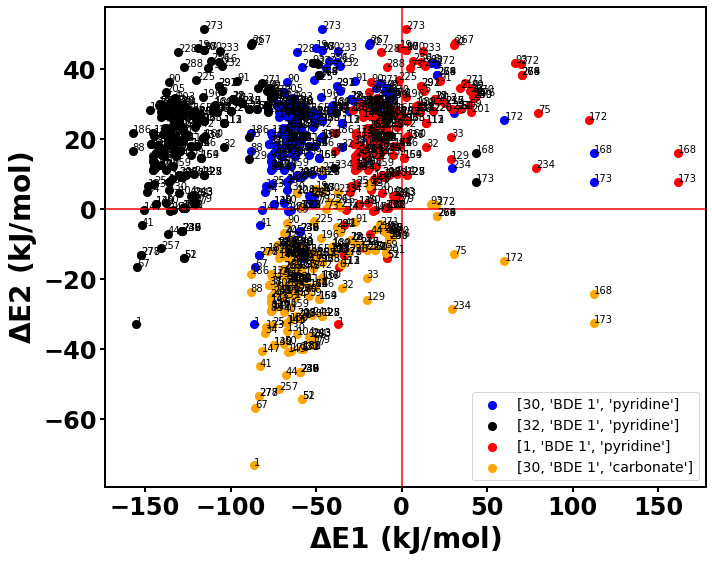

In [80]:
#Idea: Now do the same thing for different substrates:

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

annotations=succ[1]

delta='$\mathregular{\Delta} $'
fig,ax1=plt.subplots(1,1,figsize=(10,10))
solvorgas='solv'

data_id={
    'solv':1,
    'gas':0
}

di=data_id[solvorgas]
ax1.axhline(y=0, xmin=0, xmax=1,color='r')
ax1.axvline(x=0, ymin=0, ymax=1,color='r')
colors=['blue','black','red','orange']

n,_,_=np.shape(E)

for i in range(n):


    pl.scatter(ax1,E[i][:,0],E[i][:,1],xlabel=f'{delta}E1 (kJ/mol)',ylabel=f'{delta}E2 (kJ/mol)',s=50,facecolor=colors[i],edgecolor=colors[i],label=f'{bdes[i]}')
    
    for j, label in enumerate(annotations):
        plt.text(E[i][j,0],E[i][j,1],str(label))
    ax1.legend(fontsize=14)


plt.tight_layout()
plt.savefig(f'Figures/Reaction_Energy_Scatter{solvorgas}.png',dpi=600)

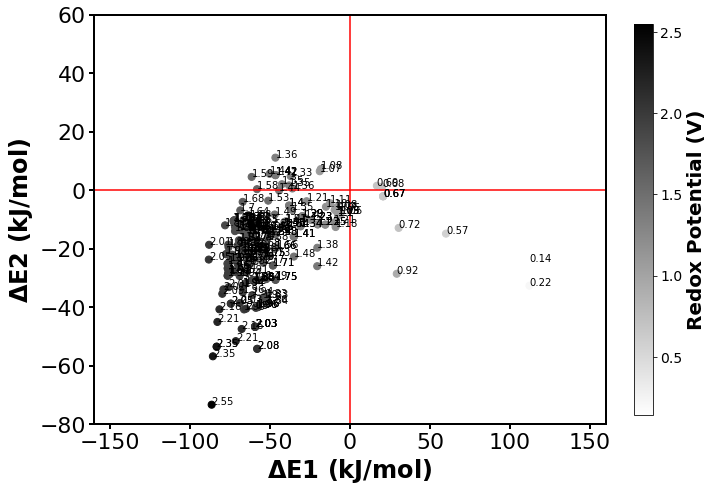

In [106]:
dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

annotations=succ[1]

delta='$\mathregular{\Delta} $'
fig,ax1=plt.subplots(1,1,figsize=(10,10))
solvorgas='solv'

data_id={
    'solv':1,
    'gas':0
}

di=data_id[solvorgas]
ax1.axhline(y=0, xmin=0, xmax=1,color='r')
ax1.axvline(x=0, ymin=0, ymax=1,color='r')
colors=['blue','black','red','orange']

n,_,_=np.shape(E)

c_s=data[1][succ[1],7]

ax1.set_xlim(-160,160)
ax1.set_ylim(-80,60)

sc=ax1.scatter(E[i][:,0],E[-1][:,1],s=50,cmap='binary',c=c_s)
for j, label in enumerate(c_s):
    plt.text(E[i][j,0],E[i][j,1],str(round(label,2)))


cb=plt.colorbar(sc,fraction=0.035, pad=0.05)
cb.set_label(label='Redox Potential (V)',size=20,weight='bold')
cb.ax.tick_params(labelsize=14) 
pl.set(ax1,ylabel=f'{delta}E2 (kJ/mol)',xlabel=f'{delta}E1 (kJ/mol)',edgecolor='black')


#pl.scatter(ax1,E[i][:,0],E[-1][:,1],xlabel=f'{delta}E1 (kJ/mol)',ylabel=f'{delta}E2 (kJ/mol)',s=50,facecolor=colors[1],edgecolor=colors[1],label=f'{bdes[-1]}')


plt.tight_layout()
plt.savefig(f'Figures/Reaction_Energy_Scatter_wRedoxPot{solvorgas}.png',dpi=600)

In [ ]:
    for j, label in enumerate(annotations):
        plt.text(E[i][j,0],E[i][j,1],str(label))
    ax1.legend(fontsize=14)